In [1]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.utils.image_utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall, Precision
from metrics import dice_loss, dice_coef, iou
import os
import cv2
import glob
import numpy as np
from PIL import Image, ImageOps
from skimage import color
from skimage import io
img = []
masks = []
IMAGE_SIZE = (256,256)

In [2]:
def training_data():
    
    img_dir = './newimg' #orginal directory
    mask_dir = './newMasks' #augmented directory
    data_img_path = os.path.join(img_dir,'*g')
    data_mask_path = os.path.join(mask_dir,'*g')

    img_files = glob.glob(data_img_path) #error @ rgb_img when removing glob.glob dunno y
    mask_files = glob.glob(data_mask_path)
    
    for f1 in img_files:
        orgImg = Image.open(f1).resize(IMAGE_SIZE)
        mirImg = ImageOps.mirror(Image.open(f1).resize(IMAGE_SIZE))
        
        
        img.append(np.array(orgImg)) 
        img.append(np.array(mirImg))
        img.append(np.array(ImageOps.flip(orgImg)))
        img.append(np.array(ImageOps.flip(mirImg)))
        
    for f2 in mask_files:
        
        orgMask = Image.open(f2).resize(IMAGE_SIZE)
        mirMask = ImageOps.mirror(Image.open(f2).resize(IMAGE_SIZE))
        
        masks.append(np.array(orgMask))
        masks.append(np.array(mirMask))
        masks.append(np.array(ImageOps.flip(orgMask)))
        masks.append(np.array(ImageOps.flip(mirMask)))
        
  
training_data()

In [3]:
img_np = np.array(img)
masks_np = np.array(masks)

In [4]:
print(img_np.shape, masks_np.shape)

(400, 256, 256) (400, 256, 256, 4)


In [5]:
#masks_np = np.array(masks_np/255.0)
masksCV = []
imgCV = []

for f2 in masks_np:
   masksCV.append(cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY))
    

#for f2 in img:
#    imgCV.append(Image.open(f2))

masksCV_np = np.array(masksCV)



In [6]:
print(img_np.shape, masksCV_np.shape)

(400, 256, 256) (400, 256, 256)


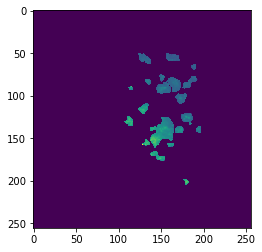

In [8]:
from matplotlib import pyplot as plt
plt.imshow(masksCV_np[0], interpolation='nearest')
plt.show()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


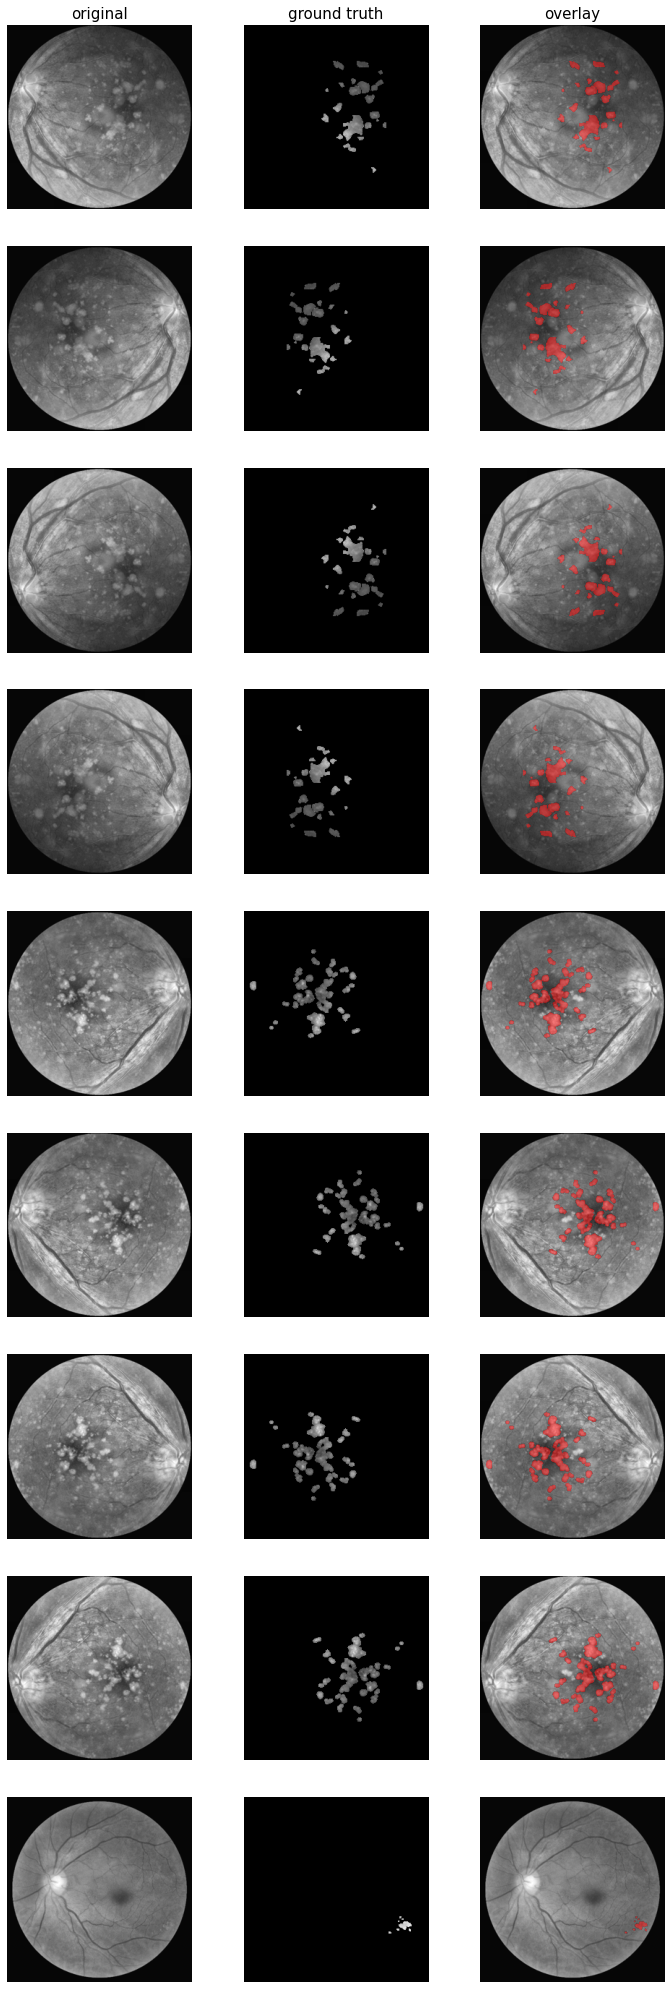

In [9]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=img_np, mask_imgs=masksCV_np, nm_img_to_plot=9, figsize=4)

In [10]:
print(img_np.max(), masksCV_np.max())

255 255


In [11]:
x = np.asarray(img_np, dtype=np.float32)/255
y = np.asarray(masksCV_np, dtype=np.float32)/255

In [12]:
print(x.max(), y.max())

1.0 1.0


In [13]:
print(x.shape, y.shape)

(400, 256, 256) (400, 256, 256)


In [14]:
x[0][0][0].shape 

()

In [15]:
#checks if image input is b&w
if(x[0][0][0].shape == ()):
  x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
    
print(x.shape, y.shape)

(400, 256, 256, 1) (400, 256, 256, 1)


In [16]:
from sklearn.model_selection import train_test_split

x_train, x_rem, y_train, y_rem = train_test_split(x, y, test_size=0.1, random_state=1)

x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_rem: ", x_rem.shape)
print("y_rem: ", y_rem.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (360, 256, 256, 1)
y_train:  (360, 256, 256, 1)
x_rem:  (40, 256, 256, 1)
y_rem:  (40, 256, 256, 1)
x_val:  (20, 256, 256, 1)
y_val:  (20, 256, 256, 1)


In [17]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("this happened")

this happened


## U Net Implementation


In [18]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4
)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping, TensorBoard


model_filename = 'segm_model_v3.h5'
callback_checkpoint =[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False),
ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-7, verbose=1),
TensorBoard()]

In [21]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

from tensorflow import keras

loss = keras.losses.BinaryCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", dice_coef, iou, Recall(), Precision()],
)

In [33]:
if(os.path.exists(model_filename)):
    model.load_weights(model_filename)

print(os.path.exists(model_filename))

True


In [34]:
with tf.device("GPU"):   
    model.fit(x=x_train, y=y_train, batch_size=4, epochs=100, validation_data=(x_val, y_val),
        callbacks=[callback_checkpoint])

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9804 - dice_coef: 0.2369 - iou: 0.1362 - recall: 0.0592 - precision: 0.9652
Epoch 1: val_loss improved from 0.01847 to 0.01844, saving model to segm_model_v3.h5
90/90 [==============================] - 21s 227ms/step - loss: 0.0198 - accuracy: 0.9804 - dice_coef: 0.2369 - iou: 0.1362 - recall: 0.0592 - precision: 0.9652 - val_loss: 0.0184 - val_accuracy: 0.9833 - val_dice_coef: 0.2238 - val_iou: 0.1266 - val_recall: 0.0266 - val_precision: 0.9814 - lr: 1.0000e-05
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9804 - dice_coef: 0.2385 - iou: 0.1374 - recall: 0.0574 - precision: 0.9628
Epoch 2: val_loss did not improve from 0.01844
90/90 [==============================] - 20s 220ms/step - loss: 0.0199 - accuracy: 0.9804 - dice_coef: 0.2385 - iou: 0.1374 - recall: 0.0574 - precision: 0.9628 - val_loss: 0.0184 - val_accuracy: 0.9833 - val_dice_coef: 0.2263 - 

In [35]:
model.load_weights(model_filename)
with tf.device("CPU"): 
    result = model.predict(x_test)

1/1 [==============================] - 3s 3s/step


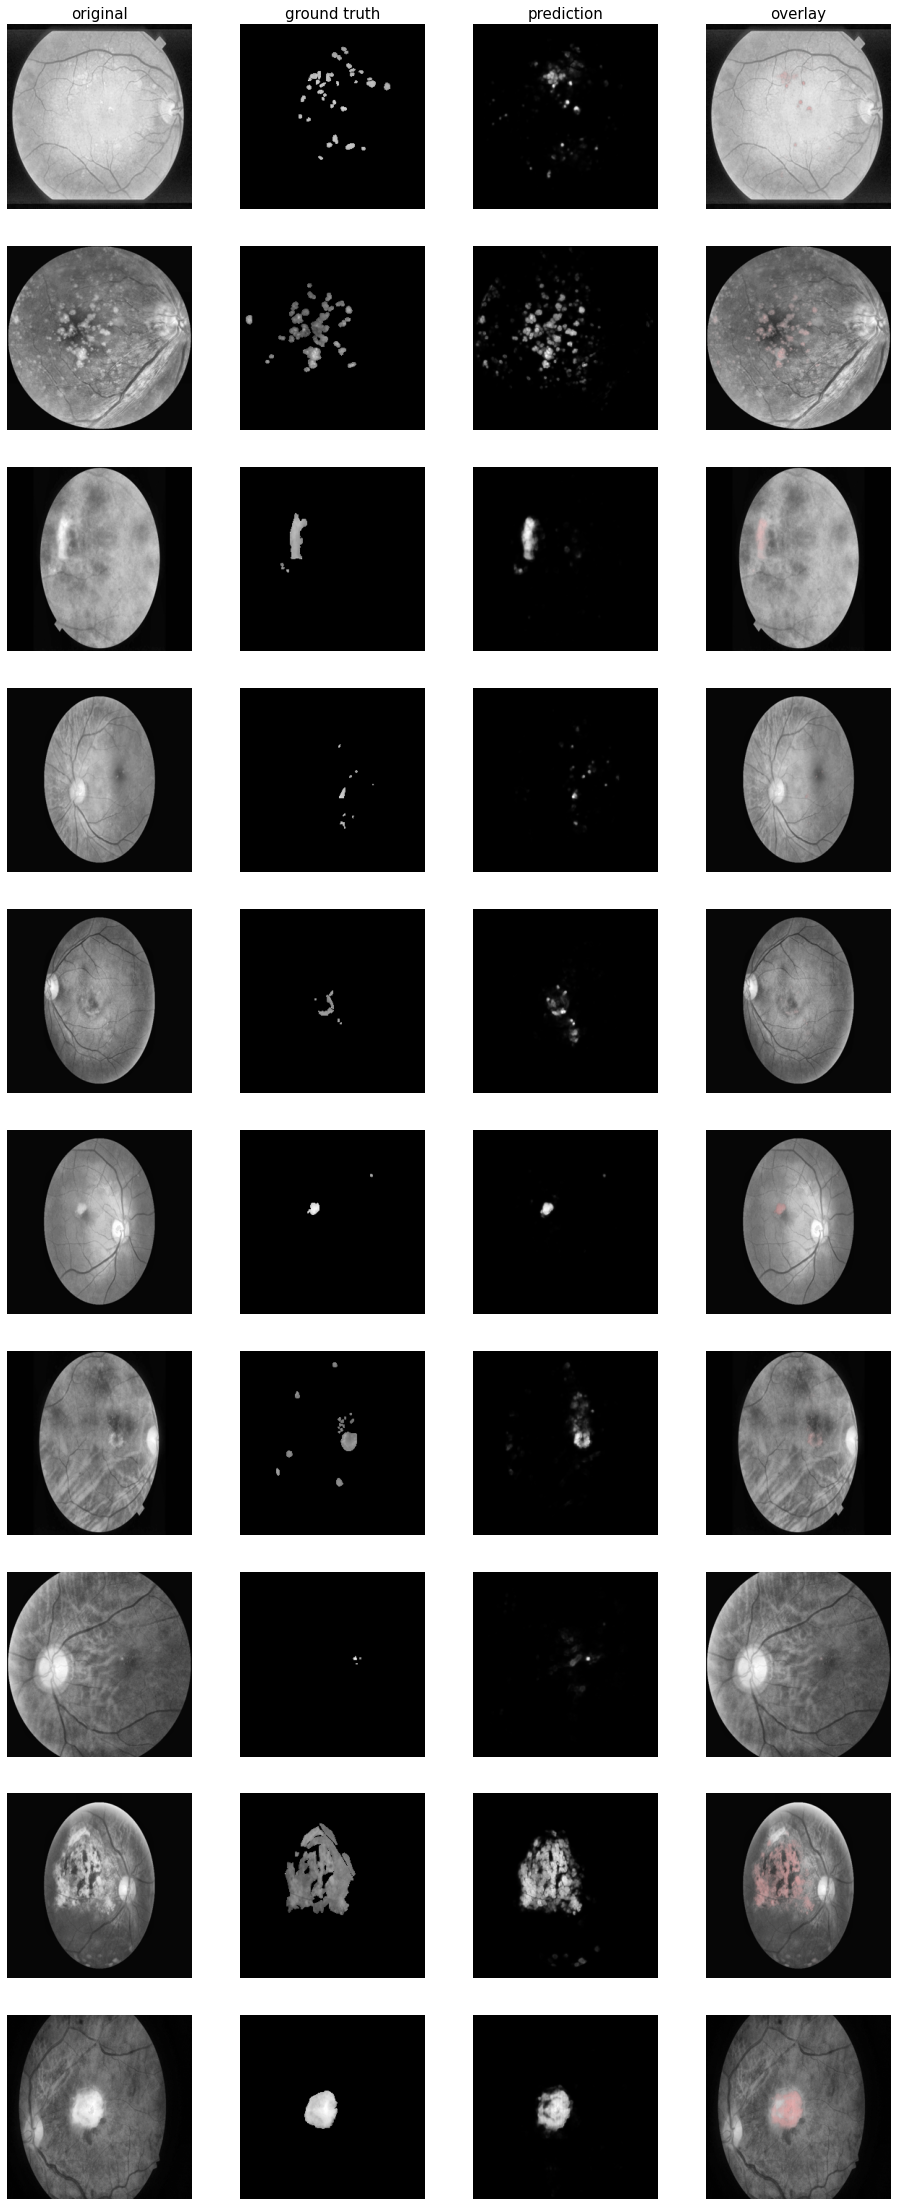

In [36]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=result, nm_img_to_plot=10)

## Implementation to random data

In [47]:
test_dir = './testingFolder' #orginal directory
data_test_path = os.path.join(test_dir,'*g')
testList = []

test_files = glob.glob(data_test_path) 

    
for f1 in test_files:
    testImg = Image.open(f1).resize(IMAGE_SIZE)      
    testList.append(np.array(testImg)) 
   

In [48]:
test_np = np.array(testList)

In [49]:
print(test_np.shape)

(10, 256, 256)


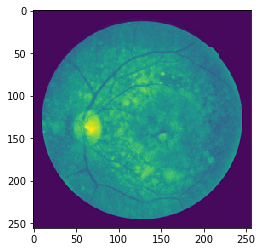

In [50]:
from matplotlib import pyplot as plt
plt.imshow(test_np[0], interpolation='nearest')
plt.show()

In [52]:
print(test_np.max())

255


In [60]:
testData = np.asarray(test_np, dtype=np.float32)/255
print(testData.max())
print(testData.shape)

1.0
(10, 256, 256)


In [62]:
testData = testData.reshape(testData.shape[0], testData.shape[1], testData.shape[2], 1)
print(testData.shape)

(10, 256, 256, 1)


In [63]:
with tf.device("CPU"): 
    testResult = model.predict(testData)

1/1 [==============================] - 1s 1s/step


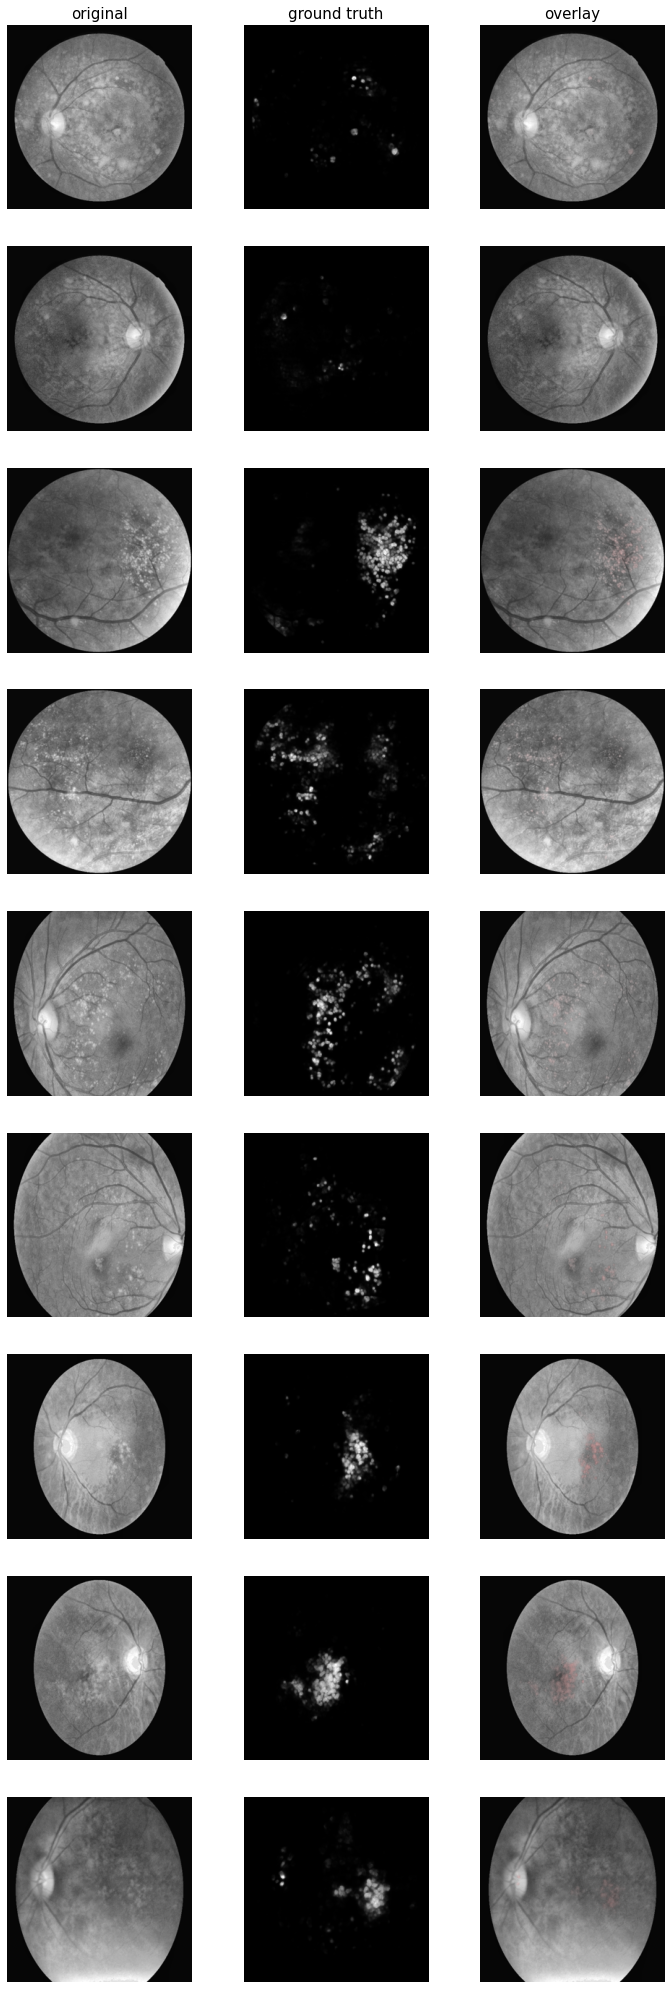

In [64]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=test_np, mask_imgs=testResult, nm_img_to_plot=9, figsize=4)